### Hackathon 1.0


##### Setting up the Environment


In [217]:
import pandas as pd
import numpy as np
import os
from termcolor import colored
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,train_test_split
from catboost import CatBoostClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

In [120]:
os.getcwd()

'c:\\Users\\Aditya.mathur\\Documents\\Workspace\\Python\\TSC-Hackathon'

#### Reading the data and performing EDA: 

Raw Data Source: Train.csv


In [121]:
raw_df = pd.read_csv('Data/Train.csv')

In [122]:
#Checking the dataset head and Shape of the raw data
print(f"data sample \n \n: {raw_df.head()}")
print(f"Shape of the data is {raw_df.shape}")

data sample 
 
:            ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic       0  
1           TOYOTA      NaN    NaN  Car Classic       1  
2           TOY

Observations:
- The Taget column is either 0 or 1 ; 
- Most of the features in the dataset are categorical ;
- Age , Number of Policies and Target are numeric

as per the observations Target should not be a Numeric column

In [123]:
# percentile list
perc =[.20, .40, .60, .80]
  
# list of dtypes to include
include =['object', 'float', 'int']

raw_df.describe(percentiles = perc, include = include).T

,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
ID,12079,12079,ID_0040R73,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy Start Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy End Date,12079,372,2010-12-31,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,11720,7,Male,7617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,12079.0,NaN,NaN,NaN,42.234539,97.492565,-6099.0,33.0,39.0,41.0,43.0,52.0,320.0
First Transaction Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No_Pol,12079.0,NaN,NaN,NaN,1.307227,0.733085,1.0,1.0,1.0,1.0,1.0,2.0,10.0
Car_Category,8341,16,Saloon,6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Colour,5117,45,Black,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Make,9603,74,TOYOTA,4975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
raw_df.info(verbose = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


As per the initial look upon the data we can see that we recieved 12079 loan applications and we have 13 columns to have profiling of the applicant.
    

Data Quality Checks:
- Checking % Missing Values - Incompleteness of the Data
- Checking the Data Quality and Outliers

In [125]:
def df_null_percentage(df = None):
    train_missing = (1 - df.count()/len(df)) * 100
    return train_missing.sort_values(ascending = False)


In [126]:
print(f"In the Raw Datasetm we could see the Nulls in the Rows as:\n\n {df_null_percentage(raw_df)}")

In the Raw Datasetm we could see the Nulls in the Rows as:

 Subject_Car_Colour        57.637222
State                     53.713056
LGA_Name                  53.613710
Car_Category              30.946270
Subject_Car_Make          20.498386
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64


Columns: Subject_Car_Colour, State ,LGA_Name are the columns with most amount of information missing,  more than 50%, we will remove them from the analysis.

Cleaning Data: Step 1: Removing Columns where more than 50 % values are NULL

In [127]:
insurance_application_df= raw_df[raw_df.columns[raw_df.isnull().sum() < len(raw_df)/2]]
print(f"Shape of the data after removing the features, having > 50 % NULLS \n: {loan_application_df.shape}")

Shape of the data after removing the features, having > 50 % NULLS 
: (12079, 11)


In [128]:
print(f"Info on the Loan_application Data: {insurance_application_df.info()}")
insurance_application_df.describe(percentiles = perc, include = include).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Make        9603 non-null   object
 9   ProductName             12079 non-null  object
 10  target                  12079 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.0+ MB
Info on the Loan_application Data: None


,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
ID,12079,12079,ID_0040R73,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy Start Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy End Date,12079,372,2010-12-31,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,11720,7,Male,7617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,12079.0,NaN,NaN,NaN,42.234539,97.492565,-6099.0,33.0,39.0,41.0,43.0,52.0,320.0
First Transaction Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No_Pol,12079.0,NaN,NaN,NaN,1.307227,0.733085,1.0,1.0,1.0,1.0,1.0,2.0,10.0
Car_Category,8341,16,Saloon,6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Make,9603,74,TOYOTA,4975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductName,12079,9,Car Classic,6485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:
- ID is a unique Identifier in the dataset
- There are 7 Distinct values for Gender which we should take a look into 
- The minimum value for Age is a negative number, hence we need to check for the Age column's sanity
- Date Columns like: Policy Start Date, Policy End Date, First Transaction Date are strings which should be of date format

In [129]:
#Date Conversion:
def date_format_conversion(df = None):
    date_cols = [col for col in df.columns if 'Date' in col]
    for col in df.columns:
        if col in date_cols:
            df[col] = pd.to_datetime(df[col])
    return df


    
insurance_application_df = date_format_conversion(insurance_application_df)


In [130]:
insurance_application_df.Age.unique()

array([   30,    79,    43,     2,    20,    37,    40,    71,    58,
          45,    51,   120,    38,    81,    69,    31,    70,    34,
           1,    41,    47,    36,    46,    48,    39,    63,    42,
          27,    64,    50,    53,    33,    23,    32,    59,    60,
          52,    54,    44,    11,    78,    28,    29,    57,    12,
          65,    35,    73,    56,    55,    26,    49,    18,    14,
          62,    25,    61,    72,    82,    67,     7,    10,    68,
          21,    76,    24,    66,     3,    93,    22,    77,    19,
          80,     9,     6,   -76,    -2,    89,    74,    75,    84,
          16,    90,   140,     8,     5,    13,    86,    15,   320,
         -12,    83,    85, -6099, -5939,     4,   -22,   144,   112,
          17,     0,    88,   -27,    87,   133,   102,   -51,   128,
         -26,   100], dtype=int64)

##### we know the ages cannot be negative numbers, hence need a stratergy to replace the negative numbers there
Strategy:
- if the age is negative and between 18 and 100, we will take the absolute value
- if age > 100  then it is sketchy, so need to make it NA
- if age is < 18, need to make it NA.

Reasoning to keep the age between 18 and 100 is that the leagal age for driving or getting a driver's licence is 18 years in Nigeria (ref: https://en.wikipedia.org/wiki/List_of_minimum_driving_ages)

Once we have the ages corrected, we can replace the NA values in age with a central value like mean.

In [131]:
def valid_age(age:int):
    if age < 0:
        if abs(age) >= 18 and abs(age) < 100:
            return int(abs(age))
    elif age < 18:
        return np.nan
    elif age > 100:
        return np.nan
    else:
        return int(age)

# Cleaning the Age extreme values
insurance_application_df.Age = insurance_application_df.Age.map(lambda x: valid_age(x))



In [132]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
Age                        7.649640
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

In [133]:
insurance_application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12079 non-null  object        
 1   Policy Start Date       12079 non-null  datetime64[ns]
 2   Policy End Date         12079 non-null  datetime64[ns]
 3   Gender                  11720 non-null  object        
 4   Age                     11155 non-null  float64       
 5   First Transaction Date  12079 non-null  datetime64[ns]
 6   No_Pol                  12079 non-null  int64         
 7   Car_Category            8341 non-null   object        
 8   Subject_Car_Make        9603 non-null   object        
 9   ProductName             12079 non-null  object        
 10  target                  12079 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


In [134]:
numerical_features = list(insurance_application_df.select_dtypes(['int64','float64']).nunique().index)

In [147]:
# Substituting NAs with Central value - Mean
# Replacing all the numeric volumns where we have Nulls with the mean of the columns to :

for column in numerical_features:

    insurance_application_df[column].fillna(round(insurance_application_df[column].mean()), inplace=True)





AttributeError: 'NoneType' object has no attribute 'astype'

In [164]:
#Converting Age to int
insurance_application_df['Age'] = insurance_application_df['Age'].map(np.int64)


In [168]:
insurance_application_df.describe(include = 'int')


,Age,No_Pol,target
count,12079.00000,12079.000000,12079.000000
mean,42.93170,1.307227,0.120457
std,11.33885,0.733085,0.325509
min,18.00000,1.000000,0.000000
25%,36.00000,1.000000,0.000000
50%,42.00000,1.000000,0.000000
75%,49.00000,1.000000,0.000000
max,100.00000,10.000000,1.000000


In [169]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

Distinct Genders in the dataset:
 ['Male' 'Female' 'Entity' 'Joint Gender' nan 'NO GENDER' 'NOT STATED'
 'SEX']


<AxesSubplot:>

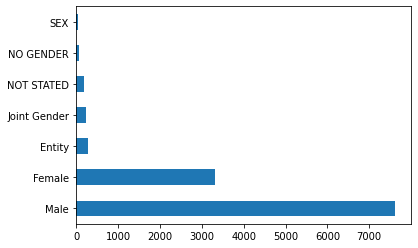

In [174]:
# Treating the values for gender
print(f"Distinct Genders in the dataset:\n {insurance_application_df.Gender.unique()}")

# Checking the distribution of gender:
insurance_application_df['Gender'].value_counts(ascending = False).plot.barh()

Since the Genders other than "Male" and "Female" are very sparse in the distribution of the dataset.
we will map those values to "others"
 

In [188]:
def gender_map(gender:object):

    if type(gender) != str:
        return 'other'
    else:
        if gender.lower() == 'male':
            return 'male'
        elif gender.lower() == 'female':
            return 'female'
        else:
            return 'other'



In [189]:
insurance_application_df.Gender= insurance_application_df.Gender.map(lambda x: gender_map(x))

<AxesSubplot:>

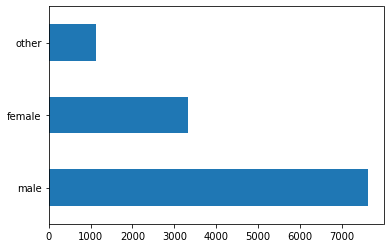

In [190]:
# Checking the distribution of gender:
insurance_application_df['Gender'].value_counts(ascending = False).plot.barh()

In [191]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

Car Category and Subject Car Make are categorical variables checking for the distribution of these features

<AxesSubplot:>

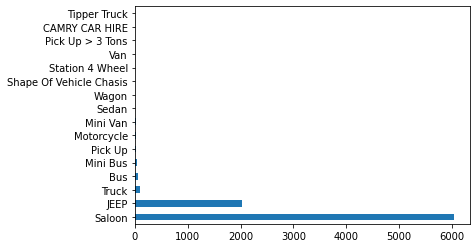

In [192]:
insurance_application_df['Car_Category'].value_counts(ascending = False).plot.barh()

<AxesSubplot:>

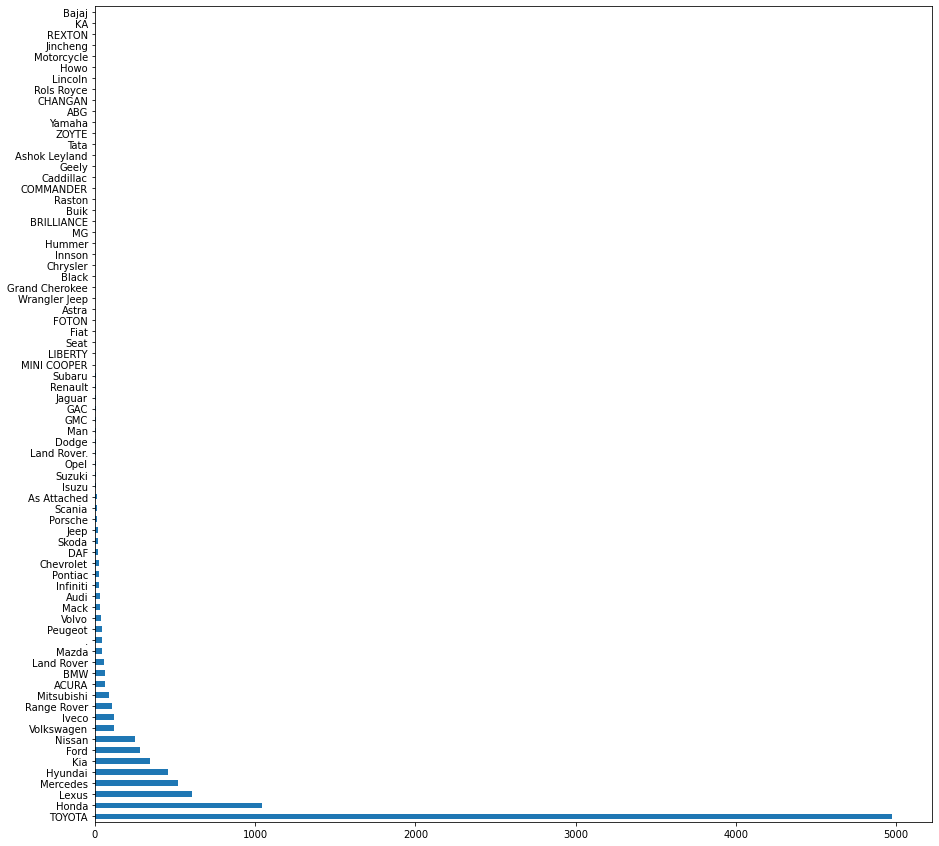

In [201]:
plt.figure(figsize=[15,15])
insurance_application_df['Subject_Car_Make'].value_counts(ascending = False).plot.barh()

We can safely replace the missing values with the mode (Central Value)  of the data for the features:
- 'Car_Category'
- 'Subject_Car_Make'


In [202]:
insurance_application_df['Subject_Car_Make'].fillna(insurance_application_df['Subject_Car_Make'].mode()[0],inplace = True)
insurance_application_df['Car_Category'].fillna(insurance_application_df['Car_Category'].mode()[0],inplace = True)

<AxesSubplot:>

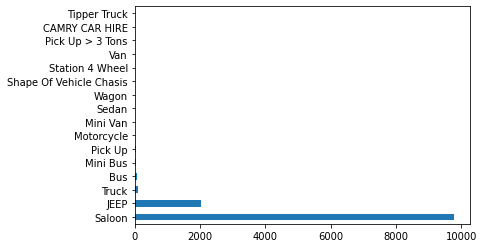

In [203]:
insurance_application_df['Car_Category'].value_counts(ascending = False).plot.barh()

<AxesSubplot:>

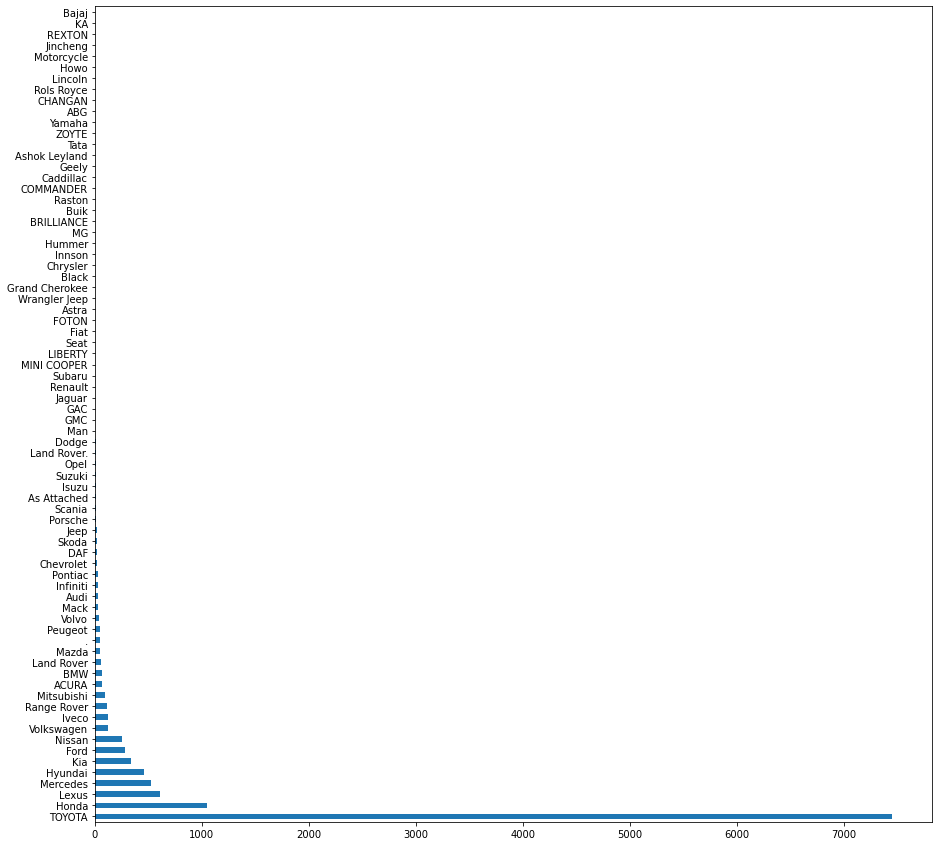

In [204]:
plt.figure(figsize=[15,15])
insurance_application_df['Subject_Car_Make'].value_counts(ascending = False).plot.barh()

In [205]:
df_null_percentage(insurance_application_df)

ID                        0.0
Policy Start Date         0.0
Policy End Date           0.0
Gender                    0.0
Age                       0.0
First Transaction Date    0.0
No_Pol                    0.0
Car_Category              0.0
Subject_Car_Make          0.0
ProductName               0.0
target                    0.0
dtype: float64

In [206]:
insurance_application_df.shape


(12079, 11)

After the clean up we have 12079 rows and 11 features.

## EDA
 - Checking for Class Imbalances
 

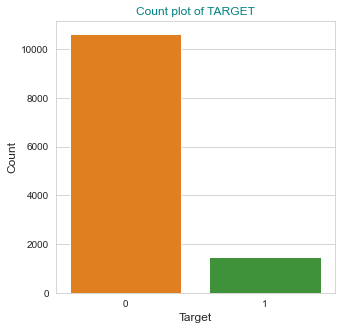

In [210]:
sns.set_style("whitegrid")
plt.figure(figsize=[5,5])
sns.countplot(insurance_application_df.target, palette= 'Paired_r')
plt.title('Count plot of TARGET', fontdict= {'fontsize': 12, 'color': 'Teal'})
plt.xlabel('Target', fontsize= 12)
plt.ylabel('Count', fontsize= 12)
plt.show()


Observations:
- we can see that the target column has clear imbalance in the favour of value '0'

Univariate Analysis:

- To Check if there are any outliers in the DataFrame
- Further treatment of data based on inferences

In [213]:
categorical_columns = list(insurance_application_df.describe(include = "O").columns)

In [215]:
print(f"Categorical Columns:\t {categorical_columns} ")
categorical_columns.pop(0) # Since Plotting ID will not make sense

Categorical Columns:	 ['ID', 'Gender', 'Car_Category', 'Subject_Car_Make', 'ProductName'] 


'ID'

In [244]:
def categorical_plots(categorical_columns,nrows = 3,kind = "countplot"):
    
    """
    Function to Plot, countplots of the categorical variables.
    
    Parameters
    -----------
    categorical_columns: list
    
    series of caltegorical columns
    
    nrows: int
    number of rows, optional
    default = 3
    
    Kind: string
    kind of plot to print
    default: countplot
    
    
    
    Return:
    ------
    None
    
    """
    sns.set(font_scale=8)
    ncols = math.ceil(len(categorical_columns)/nrows)
    #categorical_columns = categorical_columns[1:] # Id is the unique column and hence not plotting it for the count plot
    plt.figure(figsize = [120,130])
    plt.subplots_adjust(left=0.15 ,
                    bottom=0.3, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.9)
    
    for i,column in enumerate(categorical_columns,1):
        
        #print(i,column, type(column))
        
        plt.subplot(nrows,ncols,i)
        if kind == "countplot":
            sns.countplot(insurance_application_df[column]).tick_params(axis='x', rotation = 80, which='major', labelsize=40)
            
        elif kind == "boxplot":
            sns.boxplot(x= insurance_application_df[column], y = insurance_application_df["target"]).tick_params(axis='x', rotation = 80, which='major', labelsize=40)
        
        #plt.title(column,fontsize=40)
       
            
          #plt.show()

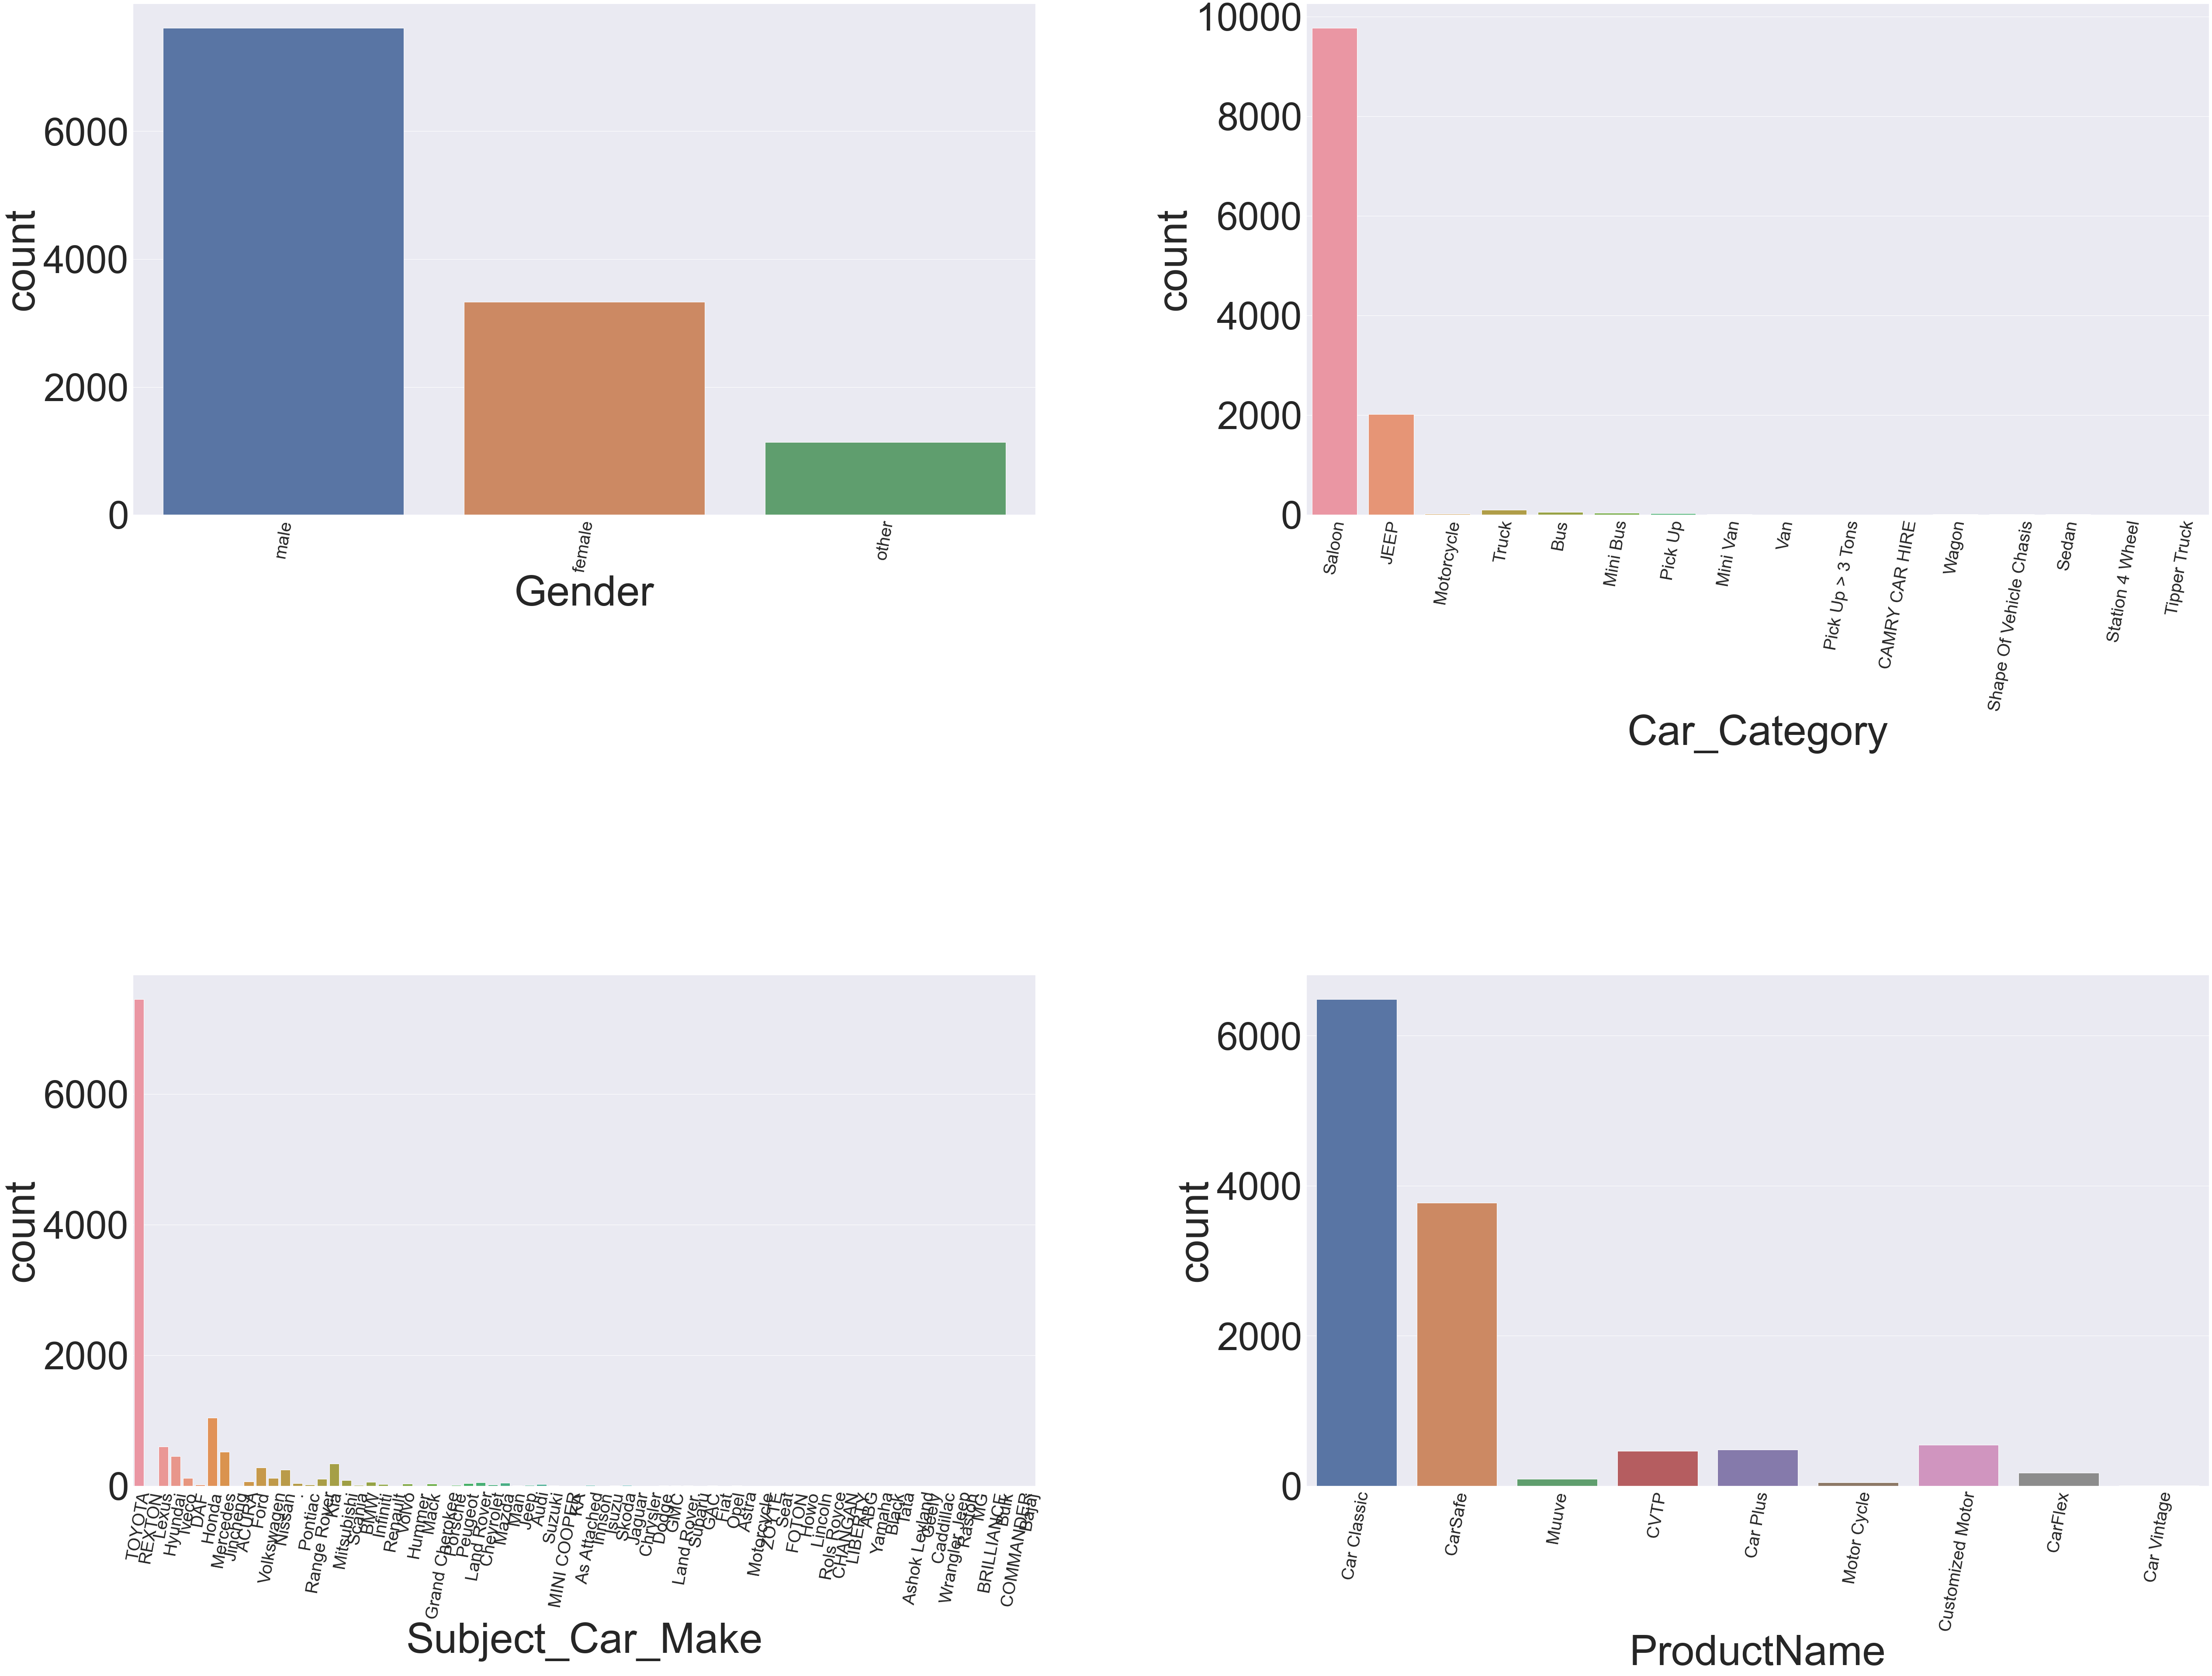

In [245]:
categorical_plots(categorical_columns)

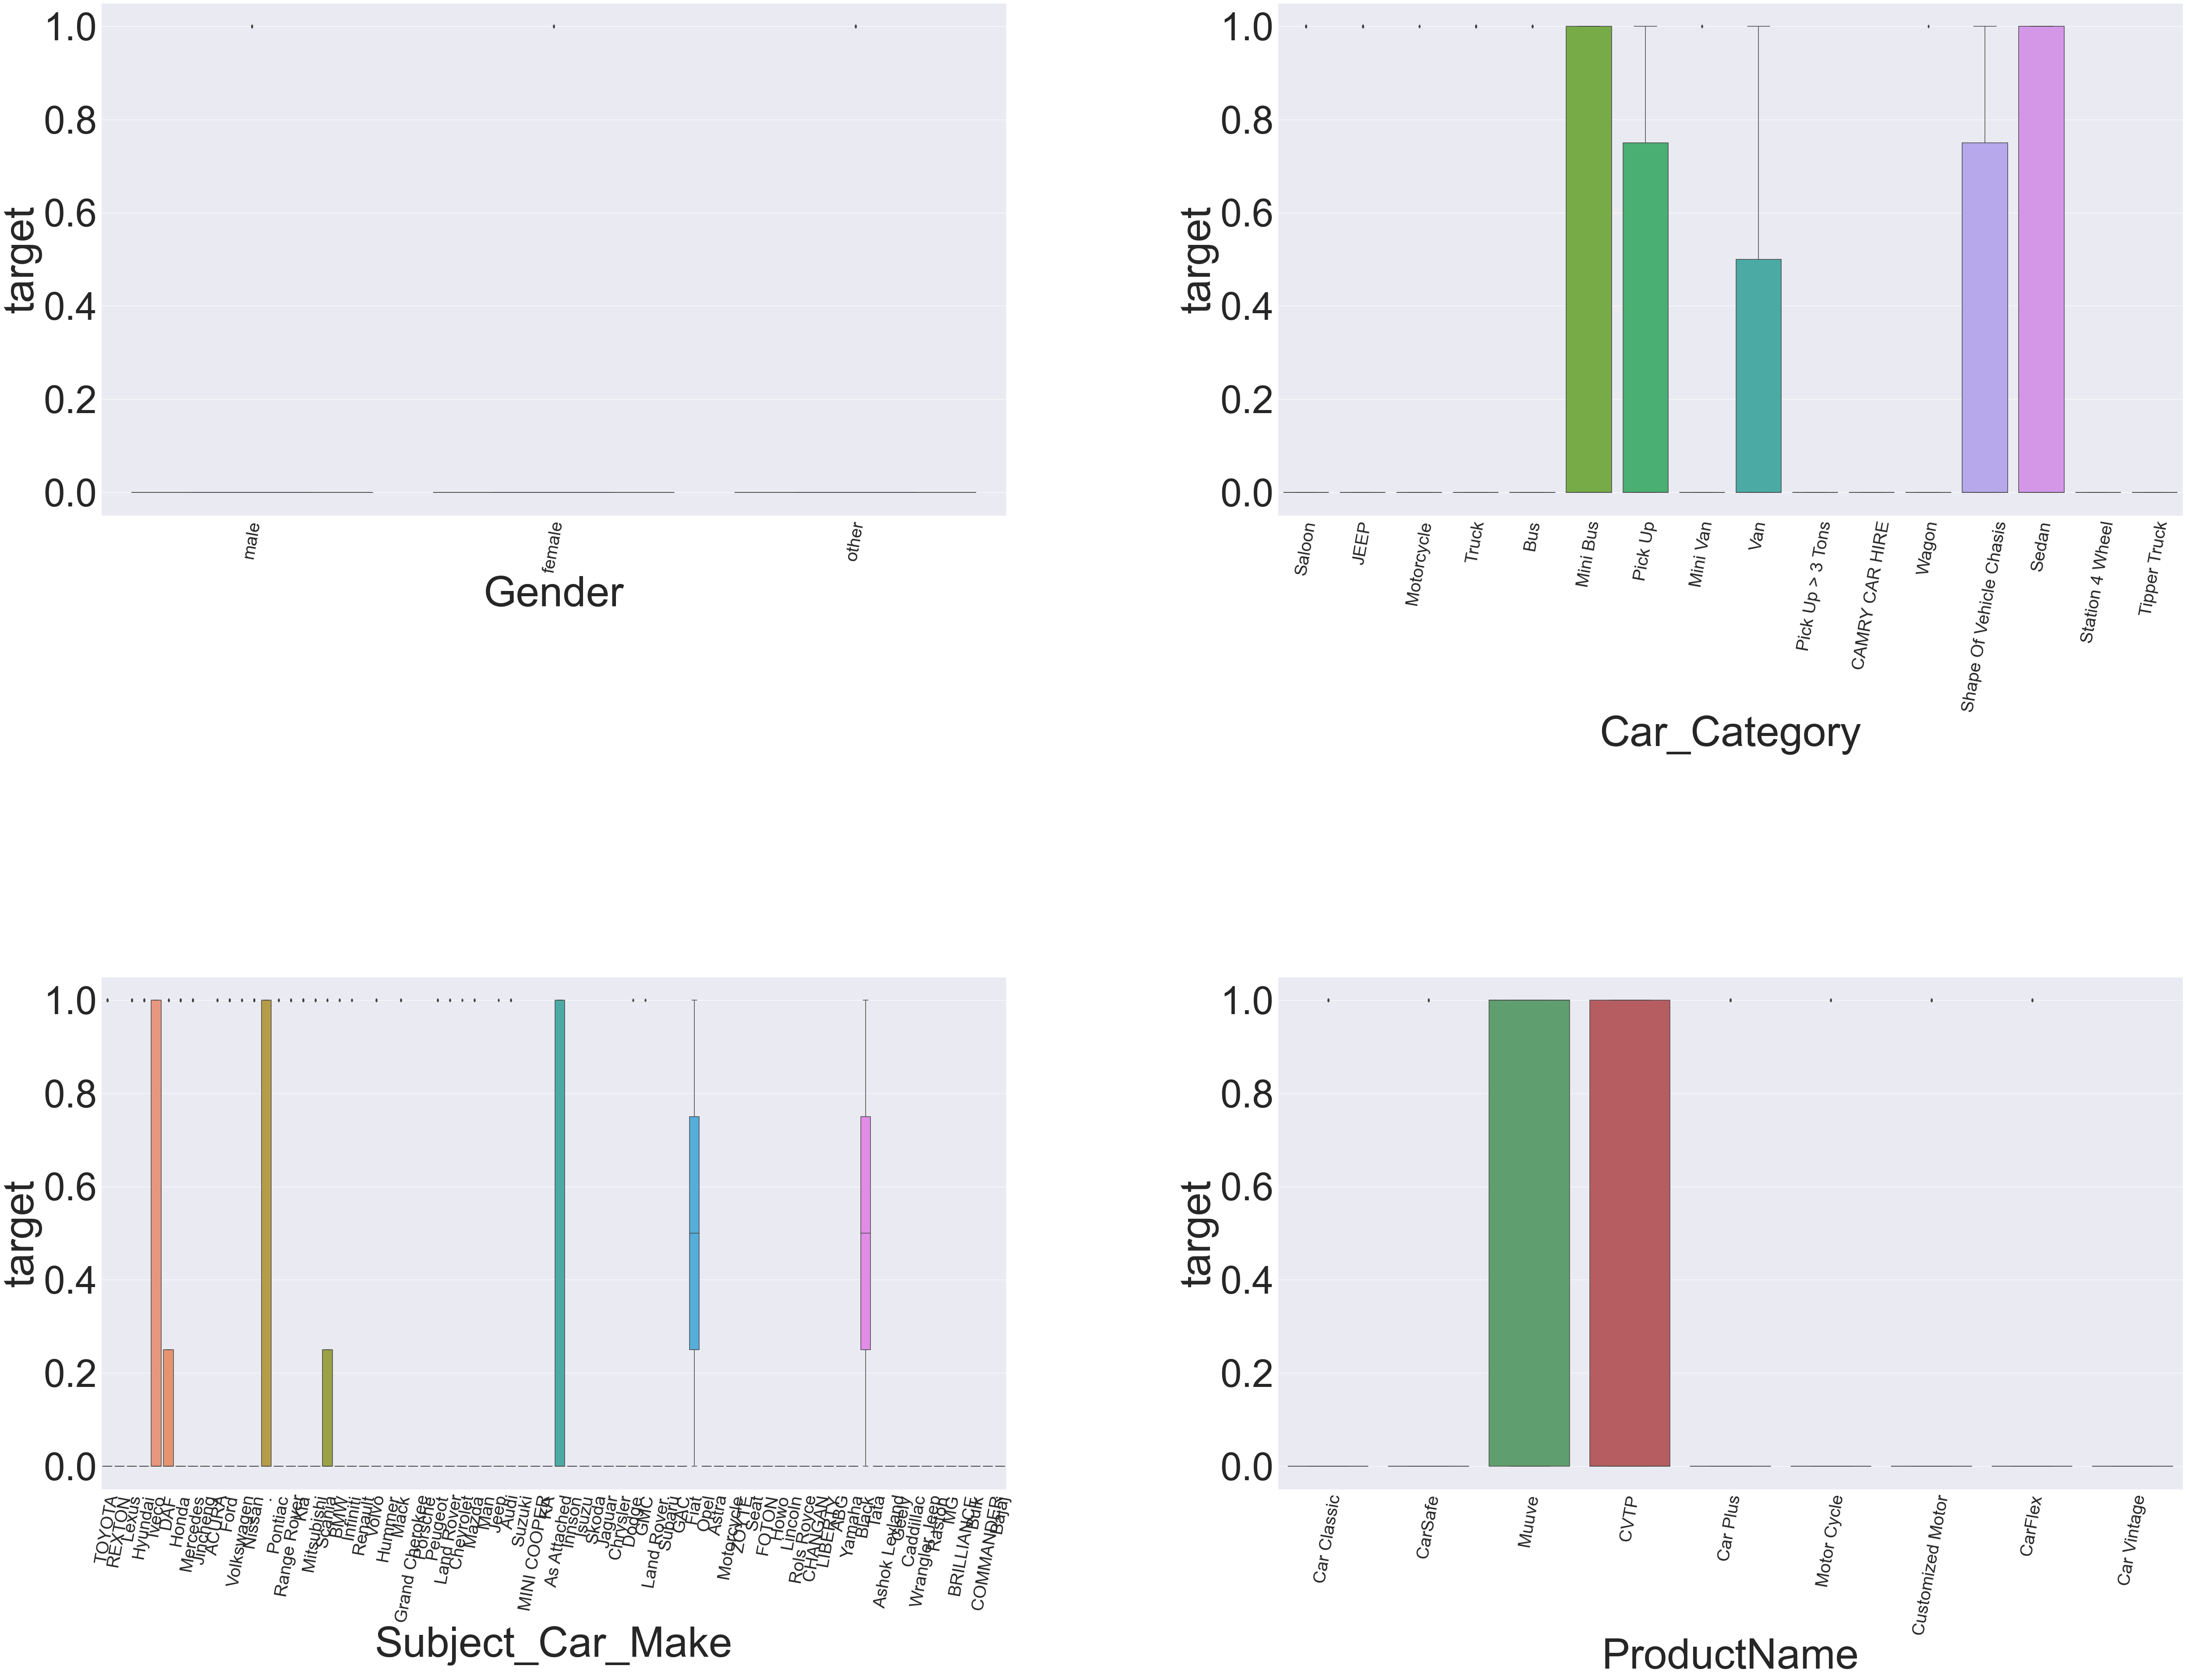

In [246]:
categorical_plots(categorical_columns,kind = "boxplot")

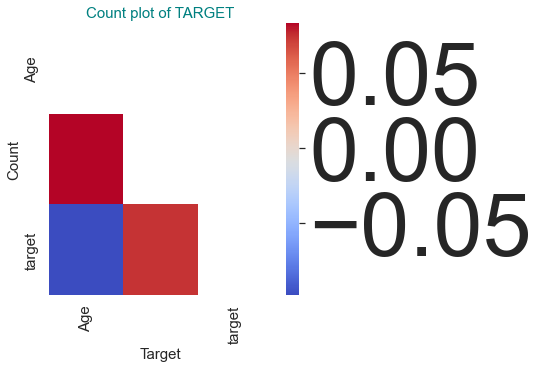

In [263]:
#Checking the correlation among varibles
sns.set_style("whitegrid")
plt.figure(figsize=[5,5])

sns.heatmap(insurance_application_df.corr(), cmap = "coolwarm",mask= np.triu(insurance_application_df.corr()))
plt.title('Count plot of TARGET', fontdict= {'fontsize': 15, 'color': 'Teal'})
plt.xlabel('Target', fontsize= 15)
plt.ylabel('Count', fontsize= 15)
plt.tick_params(axis='x', rotation = 90, which='major', labelsize=15)
plt.tick_params(axis='y', rotation = 90, which='major', labelsize=15)

plt.show()


In [258]:
insurance_application_df.corr()

,Age,No_Pol,target
Age,1.000000,0.082826,-0.097527
No_Pol,0.082826,1.000000,0.074245
target,-0.097527,0.074245,1.000000


In [265]:
print(f'Percentage of Observations in Data available after data cleaning:  {round((len(insurance_application_df.index)/12079)*100,2)} %')

Percentage of Observations in Data available after data cleaning:  100.0 %
